In [1]:
!pip install -q git+https://www.github.com/google/neural-tangents
import neural_tangents as nt
from neural_tangents import stax


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import jax.numpy as jnp
from jax import random
from jax.api import jit, grad, vmap
from jax.experimental import optimizers
from jax import device_put
import timeit
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from functools import partial
import scipy as sp
import scipy.special
import scipy.sparse
import math
import tensorflow as tf
import sys
import sklearn
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
# process the data 
def process_data(batch_block):
  image, label = batch_block['image'], batch_block['label']
  samples = image.shape[0]
  image = tf.image.rgb_to_grayscale(image).numpy()
  image = jnp.reshape(image, (image.shape[0], 32*32))
  image = jnp.array(image, dtype = np.float32)
  label = jnp.eye(10)[label]
  return {'image': image, 'label': label}


batch_size = 128
training_epochs = 5
test_data = tfds.load('cifar10', split=tfds.Split.TEST)
train_data = tfds.load('cifar10', split=tfds.Split.TRAIN)
train_data_shuff = tfds.as_numpy(
    train_data.shuffle(1024).batch(batch_size).repeat(training_epochs))
test_data_shuff = tfds.as_numpy(
    train_data.shuffle(1024).batch(batch_size))



/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.0.incomplete84GUIG/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.0.incomplete84GUIG/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.0. Subsequent calls will reuse this data.


In [0]:
def kernel_2_layer(z):
  return z*(1 - 1/math.pi*jnp.arccos(z)) + 1/math.pi * jnp.sqrt(1-z**2)

def f(phi, L):
    if L==1:
        return jnp.arccos(1/math.pi * jnp.sin(phi) + (1 - 1/math.pi *  jnp.arccos(jnp.cos(phi))   )   * jnp.cos(phi))
    elif L==0:
        return jnp.arccos(jnp.cos(phi))
    else:
        return f(phi,L-1)
    
def kernel(z, layers):
  if layers == 1:
    return kernel_2_layer(z)
  
  else:
    a = jnp.arccos(z)
    for i in range(layers-1):
      a = f(a,1)
    return jnp.cos(f(a,1)) + kernel(z,layers-1) * (1-a/math.pi) 


In [0]:
M = 1000
train_blocks = tfds.as_numpy(train_data.shuffle(1024).batch(M))
test_blocks = tfds.as_numpy(train_data.shuffle(1024).batch(M))


all_data = np.zeros((50000, 1024))
all_labels = np.zeros((50000, 10))
all_test_data = np.zeros((50000, 1024))
all_test_labels = np.zeros((50000, 10))

for i, batch in enumerate(train_blocks):
  data = process_data(batch)
  image = data['image']
  label = data['label']
  all_data[i*M:(i+1)*M,:] = image / np.outer(np.linalg.norm(image, axis = 1), (1+1e-3)*np.ones(image.shape[1]))
  all_labels[i*M:(i+1)*M,:] = label

for i, batch in enumerate(test_blocks):
  data = process_data(batch)
  image = data['image']
  label = data['label']
  all_test_data[i*M:(i+1)*M,:] = image / np.outer(np.linalg.norm(image, axis = 1), (1+1e-3)*np.ones(image.shape[1]))
  all_test_labels[i*M:(i+1)*M,:] = label



In [0]:
def eigenpro_sub_update(all_data, all_labels, block_size, eig_block_size, k, num_layers = 2):
  # do a subset for now
  
  #all_data =  all_data / np.outer(jnp.linalg.norm(all_data,axis = 1), (1+1e-3)*jnp.ones(all_data.shape[1])) 
  #all_data = all_data[0:5000,:]
  #all_labels = all_labels[0:5000,:]
  
  #get_kernel = jit(lambda X, Xp: kernel_2_layer(jnp.dot(X, Xp.T)))
  get_kernel = jit(lambda X, Xp: kernel(jnp.dot(X, Xp.T), num_layers) )
  get_res = jit(lambda K, alpha, y: y - jnp.dot(K, alpha))
  speedy_dot = jit(lambda a, b: jnp.dot(a,b))
  mse = jit(lambda res: jnp.mean(res**2))

  X_s = all_data[0:eig_block_size,:]
  K_s = get_kernel(X_s,X_s)
  w_s, v_s = sp.linalg.eigh(K_s, eigvals = (eig_block_size-1-k,eig_block_size-1))
  w_s = w_s[::-1]
  v_s = v_s[:,::-1]
  plt.loglog(w_s)
  plt.show()

  #P = v_s@  np.diag(w_s**(-1)) @ (np.eye(k+1) - w_s[-1]*np.diag(w_s**(-1)) ) @ v_s.T
  P = speedy_dot(v_s, speedy_dot(np.diag(w_s**(-1)), speedy_dot( (np.eye(k+1) - w_s[-1]*np.diag(w_s**(-1))), v_s.T ) ) )
  #P = v_s @(np.eye(k+1) - w_s[-1]*np.diag(w_s**(-1)) ) @ v_s.T

  wp, vp = sp.linalg.eigh(P @ K_s, eigvals = (eig_block_size-3, eig_block_size-1))
  

  T = 1000
  alpha = np.zeros(all_labels.shape)
  errs = np.zeros(T)
  print(w_s[-1])
  #eta = 0.8/w_s[-1]
  #eta = 500/ w_s[-3]
  eta = 100 / wp[-1]
  print("eta = %.6f" %eta)
  start_train = timeit.default_timer()
  for t in range(T):
    start = (t * block_size) % all_data.shape[0] 
    if start == 0:
      print("\n new epoch")
    X_m = all_data[start:start+block_size,:]
    y_m = all_labels[start:start+block_size,:]
    K_m = get_kernel(X_m, all_data)
    res = get_res(K_m, alpha, y_m)
    alpha[start:start+block_size,:] += eta/block_size * res
    K2 = get_kernel(X_s,X_m)
    #alpha[0:block_size,:] +=  eta/block_size * jnp.dot(jnp.dot(P, K2), res)
    alpha[0:eig_block_size,:] += - eta/block_size * speedy_dot(P, speedy_dot(K2, res))
    train_err = 10*mse(res)
    res2 = get_res(K_m, alpha, y_m)
    train2 = 10*mse(res2)
    alpha_norm = mse(alpha)
    sys.stdout.write('\r train err: %.8f | train after %.8f | alpha norm %.8f' % (train_err, train2, alpha_norm) )
    errs[t] = train_err
    if train_err < 1e-2:
      break
  train_time = timeit.default_timer() - start_train

  """
  plt.plot(np.linspace(1,len(errs),len(errs)) * block_size / all_data.shape[0], errs)
  plt.xlabel('epochs')
  plt.ylabel(r'$||K \alpha - y||$')
  plt.title('CIFAR-10 Mini-batch SGD')
  plt.tight_layout()
  plt.savefig('drive/My Drive/cifar_minibatch.pdf')
  plt.show()
  """

  return alpha, train_time

def gen_err_full_data(alpha):
  errs = []
  for i in range( int(all_test_data.shape[0]/block_size) ):
    X = all_test_data[i*block_size:(i+1)*block_size,:] 
    K = kernel_2_layer(X @ all_data.T)
    yhat = K @ alpha
    pred = np.argmax(yhat, axis = 1)
    true = np.argmax(all_test_labels[i*block_size:(i+1)*block_size,:], axis=1)
    errs += [(pred==true).mean()]
    #errs += [np.mean( (yhat - all_test_labels[i*block_size:(i+1)*block_size,:])**2 )]
  gen_err = np.mean(errs)
  return gen_err

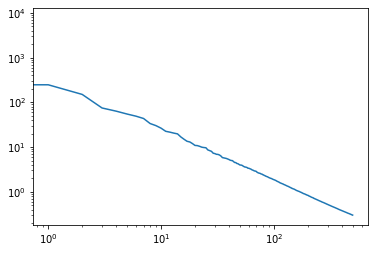

0.30012804
eta = 100.003582

 new epoch
 train err: 0.92307639 | train after 0.90888256 | alpha norm 0.00056269
 new epoch
 train err: 0.85713589 | train after 0.84473991 | alpha norm 0.00198401
 new epoch
 train err: 0.80976599 | train after 0.79852670 | alpha norm 0.00398620
 new epoch
 train err: 0.77472472 | train after 0.76433885 | alpha norm 0.00640686
 new epoch
 train err: 0.74788278 | train after 0.73808861 | alpha norm 0.00915333
 new epoch
 train err: 0.72643691 | train after 0.71713924 | alpha norm 0.01217022
 new epoch
 train err: 0.70903111 | train after 0.70006895 | alpha norm 0.01543050
 new epoch
 train err: 0.69441831 | train after 0.68572515 | alpha norm 0.01891866
 new epoch
 train err: 0.68179870 | train after 0.67337489 | alpha norm 0.02262974
 new epoch
 train err: 0.67073035 | train after 0.66251665 | alpha norm 0.02656330
 new epoch
 train err: 0.66083258 | train after 0.65277135 | alpha norm 0.03072146
 new epoch
 train err: 0.65183127 | train after 0.64393902

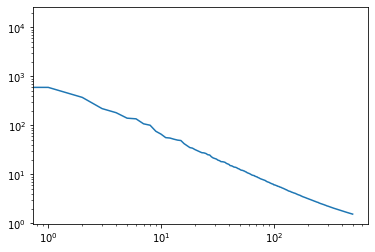

1.5379508
eta = 100.008959

 new epoch
 train err: 0.76860261 | train after 0.70543653 | alpha norm 0.00034812
 new epoch
 train err: 0.67297781 | train after 0.62041980 | alpha norm 0.00099474
 new epoch
 train err: 0.61641264 | train after 0.56919372 | alpha norm 0.00186482
 new epoch
 train err: 0.57228827 | train after 0.52900952 | alpha norm 0.00296647
 new epoch
 train err: 0.53479773 | train after 0.49478856 | alpha norm 0.00429273
 new epoch
 train err: 0.50181681 | train after 0.46462622 | alpha norm 0.00582886
 new epoch
 train err: 0.47227827 | train after 0.43757325 | alpha norm 0.00755816
 new epoch
 train err: 0.44550213 | train after 0.41303343 | alpha norm 0.00946410
 new epoch
 train err: 0.42103338 | train after 0.39060357 | alpha norm 0.01153136
 new epoch
 train err: 0.39855117 | train after 0.36996090 | alpha norm 0.01374569
 new epoch
 train err: 0.37778348 | train after 0.35088825 | alpha norm 0.01609406
 new epoch
 train err: 0.35855547 | train after 0.33320364 

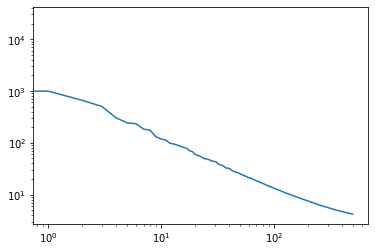

4.1826653
eta = 100.015374

 new epoch
 train err: 0.70716941 | train after 0.53967339 | alpha norm 0.00021954
 new epoch
 train err: 0.54743624 | train after 0.42139870 | alpha norm 0.00067780
 new epoch
 train err: 0.43862003 | train after 0.33981308 | alpha norm 0.00131918
 new epoch
 train err: 0.35752040 | train after 0.27858374 | alpha norm 0.00208754
 new epoch
 train err: 0.29489630 | train after 0.23101993 | alpha norm 0.00294083
 new epoch
 train err: 0.24551460 | train after 0.19330584 | alpha norm 0.00384810
 new epoch
 train err: 0.20599145 | train after 0.16296989 | alpha norm 0.00478630
 new epoch
 train err: 0.17400363 | train after 0.13830227 | alpha norm 0.00573830
 new epoch
 train err: 0.14786918 | train after 0.11805213 | alpha norm 0.00669133
 new epoch
 train err: 0.12634954 | train after 0.10130075 | alpha norm 0.00763591
 new epoch
 train err: 0.10850498 | train after 0.08734998 | alpha norm 0.00856508
 new epoch
 train err: 0.09361017 | train after 0.07565749 

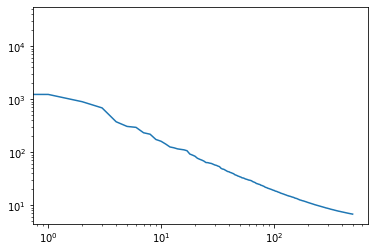

6.7978535
eta = 100.019304

 new epoch
 train err: 0.69184828 | train after 0.41816610 | alpha norm 0.00019302
 new epoch
 train err: 0.44304875 | train after 0.27332836 | alpha norm 0.00058848
 new epoch
 train err: 0.29797253 | train after 0.18709631 | alpha norm 0.00107844
 new epoch
 train err: 0.20659035 | train after 0.13184442 | alpha norm 0.00159935
 new epoch
 train err: 0.14664973 | train after 0.09503484 | alpha norm 0.00211660
 new epoch
 train err: 0.10619430 | train after 0.06981950 | alpha norm 0.00261174
 new epoch
 train err: 0.07825312 | train after 0.05215816 | alpha norm 0.00307563
 new epoch
 train err: 0.05857377 | train after 0.03955320 | alpha norm 0.00350451
 new epoch
 train err: 0.04447401 | train after 0.03040478 | alpha norm 0.00389774
 new epoch
 train err: 0.03421355 | train after 0.02366586 | alpha norm 0.00425641
 new epoch
 train err: 0.02664189 | train after 0.01863362 | alpha norm 0.00458252
 new epoch
 train err: 0.02097951 | train after 0.01482833 

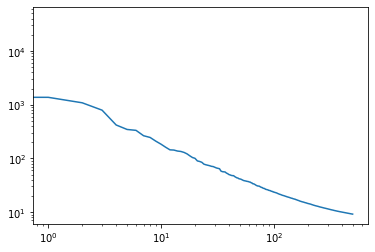

9.178396
eta = 100.021128

 new epoch
 train err: 0.68499714 | train after 0.31950861 | alpha norm 0.00018579
 new epoch
 train err: 0.35337615 | train after 0.17158516 | alpha norm 0.00052663
 new epoch
 train err: 0.19602570 | train after 0.09865078 | alpha norm 0.00089393
 new epoch
 train err: 0.11443873 | train after 0.05952838 | alpha norm 0.00123766
 new epoch
 train err: 0.07414582 | train after 0.03959131 | alpha norm 0.00128497

In [0]:
block_size = 2000
eig_block_size = 5000
k = 500
layers = [2,5,10,15,20,50,100, 200]
errs = []
train_times = []
for i,layer in enumerate(layers):
  alpha, train_time = eigenpro_sub_update(all_data, all_labels, block_size, eig_block_size, k, num_layers = layer)
  errs += [gen_err_full_data(alpha)]
  train_times += [train_time]

pd.DataFrame(train_times).to_csv('l2_loss_train_times_k%d.csv' % k)
pd.DataFrame(errs).to_csv('l2_loss_gen_k%d.csv' % k)
pd.DataFrame(layers).to_csv('layer_vals_k%d.csv' % k)

plt.plot(layers, errs, 'o')
plt.xlabel('layers')
plt.ylabel('NTK test risk')
plt.title('Effect of Depth on Generalization')
plt.savefig('drive/My Drive/depth_vs_gen.pdf')
plt.show()

plt.plot(layers, train_times, 'o')
plt.xlabel('layers')
plt.ylabel('NTK Train Time')
plt.title('Effect of Depth on Training')
plt.savefig('drive/My Drive/depth_vs_train.pdf')

In [0]:
def full_eigpro(all_data, all_labels, block_size, eig_block_size, k):
  all_data =  all_data / np.outer(jnp.linalg.norm(all_data,axis = 1), (1+1e-3)*jnp.ones(all_data.shape[1])) 
  all_data = all_data[0:5000,:]
  all_labels = all_labels[0:5000,:]
  print("processed data")
  get_kernel = jit(lambda X, Xp: kernel_2_layer(jnp.dot(X, Xp.T)))
  get_res = jit(lambda K, alpha, y: y - jnp.dot(K, alpha))
  speedy_dot = jit(lambda a, b: jnp.dot(a,b))
  mse = jit(lambda res: jnp.mean(res**2))
  
  print("computing svd")
  X_s = all_data[0:eig_block_size,:]
  K_M = get_kernel(X_s, all_data)
  print(K_M.shape)
  u,s,v = sp.sparse.linalg.svds(K_M, k, solver = 'lobpcg')
  print(s)
  #s = np.sqrt(all_labels.shape[0] / eig_block_size)*s
  
  K_MM = get_kernel(all_data, all_data)
  w, v2 = sp.linalg.eigh(K_MM, eigvals = (K_MM.shape[0]-k-1, K_MM.shape[0]-1))

  plt.loglog(w[::-1])
  plt.loglog(s[::-1])
  plt.show()

  print(v.shape)

  print("acceleration: %.7f" % (np.amax(s) / np.amin(s)))

  print("s vector")
  print(s)

  tau = 1
  #P_inner = speedy_dot( np.diag(s**(-1)) ,  np.eye(k) - tau* np.amin(s)*np.diag(s**(-1))  )
  P_inner = np.eye(k) - tau*np.amin(s) * np.diag(s**(-1))


  #eta = 0.01/np.amin(s)
  #eta = .1*np.sqrt(block_size /np.amin(s) )
  eta = .1/np.amin(s)

  T = 500

  alpha = np.zeros(all_labels.shape)
  errs = np.zeros(T)
  for t in range(T):
    start = (t * block_size) % all_data.shape[0] 
    if start == 0:
      print("\n new epoch")
    X_m = all_data[start:start+block_size,:]
    y_m = all_labels[start:start+block_size,:]
    K_m = get_kernel(X_m, all_data)
    res = get_res(K_m, alpha, y_m)
    alpha[start:start+block_size,:] += eta/block_size * np.array(res)
    #K2 = get_kernel(X_s,X_m)
    #alpha[0:block_size,:] +=  eta/block_size * jnp.dot(jnp.dot(P, K2), res)
    #alpha[0:eig_block_size,:] += - eta/block_size * speedy_dot(P, speedy_dot(K2, res))
    prec_update = speedy_dot(P_inner, speedy_dot( v, speedy_dot(K_m.T, res) ) )
    alpha += - eta / block_size * np.array( speedy_dot(v.T, prec_update) )
    train_err = 10*mse(res)
    res2 = get_res(K_m, alpha, y_m)
    train2 = 10*mse(res)
    alpha_norm = mse(alpha)
    sys.stdout.write('\r train err: %.8f | train after %.8f | alpha norm %.8f' % (train_err, train2, alpha_norm) )
    errs[t] = train_err

  return

block_size = 5000
eig_block_size = 2500
k = 350
full_eigpro(all_data, all_labels, block_size, eig_block_size, k)
